In [1]:
import sys
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
import toml
import time
from ipywidgets import *
import cv2
import uuid
from absl import logging
logging.set_verbosity(0)

import copy
import os
import json

from datetime import datetime

In [2]:
import sys
sys.path.append("/Users/anujraaj/ati/mule")

In [3]:
from lc_utils import load_imu_data
from submap import Submap
from lc_utils import combine_yelli_poses, get_inverse_yelli_pose, imu_pose_estimate, normalize_pose

In [4]:
from ati.perception.lidar import lidar_pb, lidar_utils
from ati.perception.lidar.lidar_voxel import voxel_filter
from ati.perception.utils.voxel_filter_utils import voxel_filter_fast
from ati.perception.lidar.lidar_frame import *
from ati.slam.yelli import utils, grid
from utils.imu_tracker import ImuTracker

data [0.3 0.  0.2 0.6 0.2 1.  0.2 0.3 0.9 0.3 0.4 0.3 0.6 0.9 0.1]
unique [0.  0.1 0.2 0.3 0.4 0.6 0.9 1. ]
sorted [0.  0.1 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.4 0.6 0.6 0.9 0.9 1. ]
indices of unique values [ 0  1  2  5  9 10 12 14]
argsort [ 1 14  2  4  6  0  7  9 11 10  3 12  8 13  5]


In [5]:
max_frames = 32000 
# data_dir = "/atidata/demo/SLLumax/2021-07/21-07-2021/map_raw_data/2021-07-21-10-50-46-mini20-02-manual-sllmax_map/"
data_dir =r"/atidata/customer/Bosch/2021-08-30-16-24-40-minimule-11-3-manual-Bosch-32beam_capture_2"
data_dir=r"/Users/anujraaj/robotics/SLAM-loop-closure/data/indoor-run/2021-12-29-11-52-57-minimule-11-2-manual-bosch_nashik_indoor"
data_dir=r"/Users/anujraaj/robotics/SLAM-loop-closure/data/2021-11-11-15-31-42-minimule-11-2-manual-floor_1__mapping"

In [6]:


bootstrap_frames =20

grid_res = 0.02
grid_alpha =1
num_submap_range_data = 90
alpha= 1.05
start_frame = 50

grid_params = {
    "x": (-0.1, 0.1),
#    "x": (-0.2, 0.2),
#    "x": (-0.4, 0.4),
#    "y": (-0.02, 0.30),
    "y": (-0.20, 0.30),
#    "y": (-0.40, 0.60),
    "theta": (-0.2, 0.2),
#    "num_x": 11,
#    "num_x": 22,
#    "num_x": 44,
#    "num_y": 17,
#    "num_y" : 26,
#    "num_y" : 52,
#    "num_t": 41,
    "num_t": 100,
    
}

grid_params['num_x'] = int((grid_params['x'][1] - grid_params['x'][0])/grid_res + 1)
grid_params['num_y'] = int((grid_params['y'][1] - grid_params['y'][0])/grid_res + 1)



zmin, zmax = 0.3, 2.5

In [7]:
z_slices = [(zmin,zmax)]
print("Using Z slices:", z_slices)

Using Z slices: [(0.3, 2.5)]


In [8]:
imu_data = load_imu_data(data_dir)
imu_tracker = ImuTracker()
imu_bias_initialized = False
i = 0
while not imu_bias_initialized:
    imu_bias_initialized = imu_tracker.get_initial_gyro_bias(imu_data.iloc[i])
    i += 1


In [9]:
pose = np.array([0.,0., np.pi/2])
prev_pose = pose.copy()
spose = pose #local submap pose

In [10]:
submaps, active_submaps, finished_submaps = [], [], [] #active_submaps contain two two at a time -- implementation for overlapping submaps
best_scores = []
node_poses = [] #? poses of inserted frames in the global frame
inserted_frame_ids=[] #frame_id for inserted frame
submap = Submap(spose.copy(), grid_res, grid_alpha)
active_submaps.append(submap)

In [11]:
frame_id=0
try:
    lpb = lidar_pb.LidarSmallPb(data_dir)
except:
    lpb = lidar_pb.LidarPb(data_dir)
prev_frame_time, prev_frame = lpb.get_frame(start_frame - 2)
num_frames = np.minimum(len(lpb.list_frames()), max_frames)
print(f"total frames {num_frames}")
for frame_id in range(start_frame, num_frames - 1):
    #if frame_id % 2 != 0:
        #continue
    try:
        frame_time, frame = lpb.get_frame(frame_id)
    except:
        print(f"skipping {frame_id}. divide-by-zero error")
        continue

    frame = np.copy(frame[:, :6]).astype(np.float64)
    frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
    frame = frame[(frame[:,2] > zmin) & (frame[:,2] < zmax)]
    filtered_frame,_ = voxel_filter_fast(voxel_filter(frame, voxel_size=0.05), trunc=False, voxel = 0.5)
    frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)
    
    if frame_id < start_frame + bootstrap_frames:
        print("Num Bootstrap insertions", active_submaps[0].num_insertions)
        spose = combine_yelli_poses(pose, get_inverse_yelli_pose(active_submaps[0].pose)) # pose wrt submap origin
        node_poses.append(pose)
        inserted_frame_ids.append(frame_id)
        active_submaps[0].insert_points(frame_z, spose, frame_id, node_id = len(node_poses)-1 )
#         frame_list.append(frame_id)
#         poses.append(pose)
        prev_insert_ts = frame_time
        prev_frame_time, prev_frame = frame_time, frame
        last_inserted_pose = pose.copy()
        continue
    
    relevant_imu_data = imu_data[imu_data["time"].between(prev_frame_time, frame_time)]
    for imu_idx in range(relevant_imu_data.shape[0]):
        imu_tracker.add_imu_data(relevant_imu_data.iloc[imu_idx])
    
    pose_estimate = imu_pose_estimate(imu_tracker, frame_time, pose) #only theta around which we need to search changes
    spose_estimate = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[0].pose),pose_estimate)
    search_space = utils.grid_space(center=spose_estimate, **grid_params)
    scores = active_submaps[0].search(filtered_frame, search_space, count_once = False)
    best = np.argmax(scores)
    best_scores.append(scores[best])
    
    spose = search_space[best]
    pose = combine_yelli_poses(active_submaps[0].pose, spose)
    if (np.linalg.norm(pose[:2]-last_inserted_pose[:2])> 0.1 or (prev_insert_ts - frame_time)>1) :

        node_poses.append(pose)
        inserted_frame_ids.append(frame_id)
        active_submaps[0].insert_points(frame_z, spose, frame_id, node_id=len(node_poses)-1)
        if len(active_submaps) ==1:
        
            if active_submaps[0].num_insertions >= int(num_submap_range_data/2):
                active_submaps.append(Submap(pose.copy(), grid_res, grid_alpha))
                s2pose = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[1].pose),pose)
                active_submaps[1].insert_points(frame_z,s2pose, frame_id, node_id=len(node_poses)-1)
                #print(f"spose {spose}, s2pose {s2pose}")
                
        else:
            
            s2pose = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[1].pose),pose)
            active_submaps[1].insert_points(frame_z,s2pose, frame_id, node_id=len(node_poses)-1)
            #print(f"len else spose {spose}, s2pose {s2pose}")
            
        if active_submaps[0].num_insertions >= num_submap_range_data - 1:
            active_submaps[0].finish()
            finished_submaps.append(active_submaps.pop(0))
            active_submaps.append(Submap(pose.copy(), grid_res, grid_alpha))
            s2pose = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[1].pose), pose)
            active_submaps[1].insert_points(frame_z,s2pose, frame_id, node_id=len(node_poses)-1)
        
        #print("num active submaps", len(active_submaps))
        prev_insert_ts = frame_time
        last_inserted_pose = pose.copy()
    if frame_id % 250 == 0:
        print(f"frame:{frame_id} scores:{best_scores[-1]} best pose:{pose}  ")
    prev_frame_time, prev_frame = frame_time, frame
node_poses = np.array(node_poses)
inserted_frame_ids = np.array(inserted_frame_ids)
# print(f"final pose {poses[-1]}")
    

total frames 27638
Num Bootstrap insertions 0
Num Bootstrap insertions 1
Num Bootstrap insertions 2
Num Bootstrap insertions 3
Num Bootstrap insertions 4
Num Bootstrap insertions 5
Num Bootstrap insertions 6
Num Bootstrap insertions 7
Num Bootstrap insertions 8
Num Bootstrap insertions 9
Num Bootstrap insertions 10
Num Bootstrap insertions 11
Num Bootstrap insertions 12
Num Bootstrap insertions 13
Num Bootstrap insertions 14
Num Bootstrap insertions 15
Num Bootstrap insertions 16
Num Bootstrap insertions 17
Num Bootstrap insertions 18
Num Bootstrap insertions 19
frame:250 scores:1575.0 best pose:[ 3.38255713e-07 -2.26198016e-02  1.57284716e+00]  
frame:500 scores:1476.0 best pose:[ 4.25969982e-06 -2.55047192e-02  1.57312360e+00]  
frame:750 scores:1470.0 best pose:[ 3.19501054e-04 -2.88331003e-02  1.57312916e+00]  
frame:1000 scores:1341.0 best pose:[ 7.83852567e-05 -3.25311871e-02  1.57322174e+00]  
frame:1250 scores:3155.0 best pose:[ 0.26745323 15.75455752  1.65223461]  
frame:1500 

frame:24750 scores:5049.0 best pose:[33.87776033 84.79772849  1.36395078]  
frame:25000 scores:3016.0 best pose:[ 39.18990177 103.25559776   1.32206922]  
frame:25250 scores:3261.0 best pose:[ 44.87403192 121.62470443   1.28395512]  
frame:25500 scores:1453.0 best pose:[ 39.31546734 132.50728193   2.92934181]  
frame:25750 scores:1861.0 best pose:[ 23.31454151 136.9262862   -2.83807064]  
frame:26000 scores:2440.0 best pose:[ 17.80018246 121.07777011  -1.78455116]  
frame:26250 scores:3364.0 best pose:[ 12.52591202 102.87035335  -1.76670789]  
frame:26500 scores:1918.0 best pose:[ 7.76965238 86.13028953 -1.79049303]  
frame:26750 scores:4552.0 best pose:[ 4.90634284 77.49305998 -1.8172284 ]  
frame:27000 scores:3541.0 best pose:[-0.68199975 59.1091041  -1.8320178 ]  
frame:27250 scores:2941.0 best pose:[-5.97018436 40.72513322 -1.78255345]  
frame:27500 scores:3197.0 best pose:[-11.35236422  22.78298265  -1.83610597]  


In [12]:
node_poses

array([[  0.        ,   0.        ,   1.57079633],
       [  0.        ,   0.        ,   1.57079633],
       [  0.        ,   0.        ,   1.57079633],
       ...,
       [-12.97121408,  17.60503815,  -1.85686197],
       [-12.9996604 ,  17.50911867,  -1.85623002],
       [-13.05298782,  17.39972439,  -1.86199029]])

In [13]:
import pickle

with open("./maps/3/submaps-node_poses-inserted_frame_ids.pkl", 'wb') as f:
    pickle.dump((finished_submaps, node_poses, inserted_frame_ids),f)

In [14]:
# with open("maps/2/submaps-node_poses-inserted_frame_ids.pkl", 'rb') as f:
#     random = pickle.load(f)

(-19.54351307608416,
 124.42124583108715,
 -18.826141733833914,
 157.9455518157124)

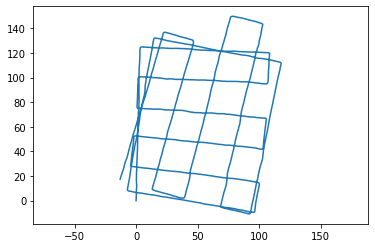

In [15]:
node_poses = np.array(node_poses)
st = 0; stp = -1
plt.figure()
plt.plot(node_poses[st:stp,0], node_poses[st:stp,1], )
plt.axis('equal')


In [16]:
node_poses

array([[  0.        ,   0.        ,   1.57079633],
       [  0.        ,   0.        ,   1.57079633],
       [  0.        ,   0.        ,   1.57079633],
       ...,
       [-12.97121408,  17.60503815,  -1.85686197],
       [-12.9996604 ,  17.50911867,  -1.85623002],
       [-13.05298782,  17.39972439,  -1.86199029]])

<IPython.core.display.Javascript object>


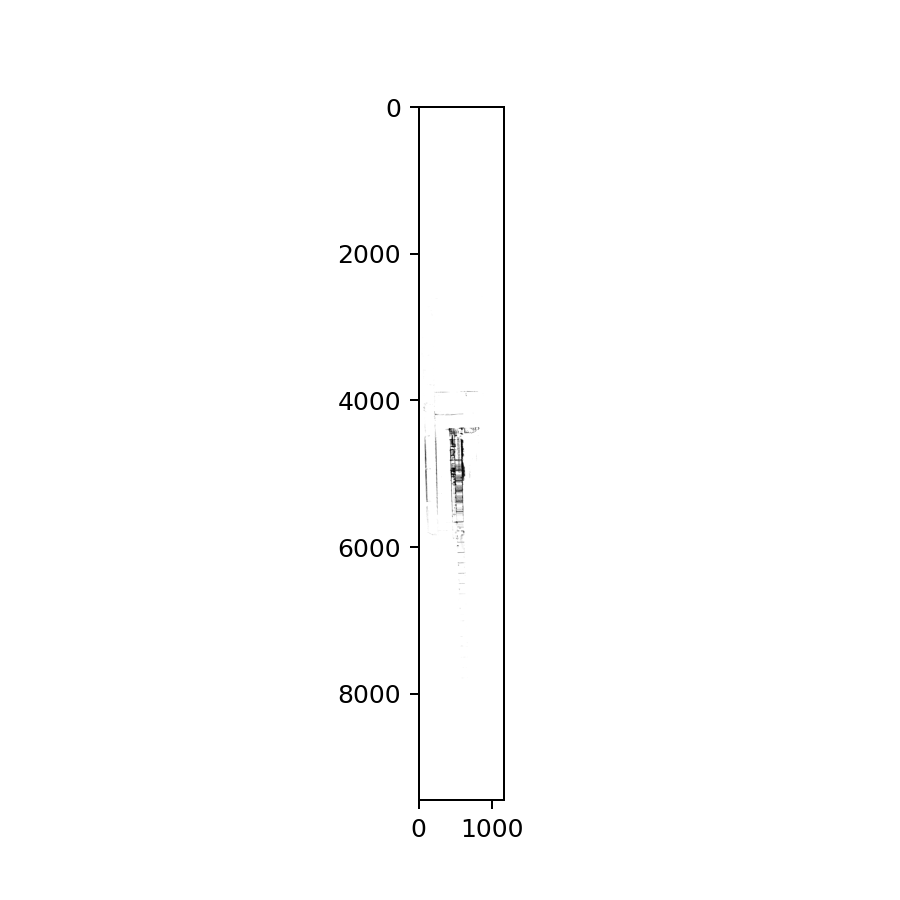

In [25]:
# %matplotlib inline
%matplotlib notebook
# %matplotlib notebook
plt.figure(figsize = (5,5))
#plt.imshow(1-(finished_submaps[2].grid.grid.T> 0), cmap='gray') 
if finished_submaps[0].iscompressed:
        finished_submaps[0].decompress_data()
plt.imshow(1 - (finished_submaps[0].grid.grid.T>0), cmap='gray') 
#print(np.sum(finished_submaps[1].grid.grid >0))

In [26]:
print( len(finished_submaps), len(node_poses), len(inserted_frame_ids))

300 13275 13275


In [30]:
import branch_bound as bb
from importlib import reload
from constraint import Constraint
import pg

reload(bb)
reload(pg)

<module 'pg' from '/Users/anujraaj/robotics/SLAM-loop-closure/pg.py'>

In [37]:
x_search_window = (-5,5)
y_search_window = (-5,5)
angle_search_window = (-np.pi/6, np.pi/6)
score_th=10

node_dists = np.cumsum(np.linalg.norm(node_poses[1:,:2]-node_poses[:-1,:2], axis = 1))
node_dists = np.concatenate(([0],node_dists))
print(len(node_dists), len(node_poses))

13275 13275


In [ ]:
constraints=[]
for sid in range(len(finished_submaps)):
#for sid in range(2):
    submap = finished_submaps[sid]
    if submap.iscompressed:
        submap.decompress_data()
    hgrids =  bb.compute_hierarchical_grid(submap.grid, num_levels=4)
    for nid in range(len(node_poses)):
        npose = node_poses[nid]
        dist = np.linalg.norm(npose[:2] - submap.pose[:2])
        node_dist = abs(node_dists[nid] - node_dists[submap.node_ids[0]])
        if node_dist < 20:
            continue
        if nid not in submap.node_ids and (dist < 10):
            fr_id = inserted_frame_ids[nid]
            ts, frame = lpb.get_frame(fr_id)
            frame = np.copy(frame[:, :6]).astype(np.float64)
            frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
            frame = frame[(frame[:,2] > zmin) & (frame[:,2] < zmax)]
            frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)
            if len(frame_z) < 500:
                continue
            #Check all quadrants have points
            if (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] > 0)) <10) or \
            (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] < 0)) <10) or \
            (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] > 0)) <10) or \
            (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] < 0)) <10):
                continue
            frame_z,_ = voxel_filter_fast(frame_z, trunc=False, voxel = 0.25)  
            
            spose_estimate = combine_yelli_poses(get_inverse_yelli_pose(submap.pose), npose)
            hpose = bb.hierarchical_search(hgrids, spose_estimate, frame_z,
                                        x_search_window,y_search_window,angle_search_window
                                        , max_range = 60, score_th = score_th)
            if hpose is not None:    
                print("sid, nids, pose",[submap.node_ids[0], nid], hpose)
                constraints.append(Constraint([submap.node_ids[0], nid], hpose))
    print(f"Submap {sid} done..")
    submap.compress_data()

Submap 0 done..
Submap 1 done..
Submap 2 done..
Submap 3 done..
Submap 4 done..
sid, nids, pose [220, 6396] [-0.20261876  2.96598315  1.54629337]
Submap 5 done..
Submap 6 done..
Submap 7 done..
Submap 8 done..
Submap 9 done..
Submap 10 done..
Submap 11 done..
sid, nids, pose [528, 2649] [-0.22561458  5.8878218  -1.47862019]
sid, nids, pose [528, 2652] [-0.20597163  5.4418819  -1.48627917]
Submap 12 done..
sid, nids, pose [572, 2583] [-0.119348    8.93678392 -1.52635039]
sid, nids, pose [572, 2584] [-0.11261697  8.76705554 -1.52524482]
sid, nids, pose [572, 2585] [-0.1393891   8.57929063 -1.52818808]
sid, nids, pose [572, 2586] [-0.14380176  8.4346979  -1.53313421]
sid, nids, pose [572, 2588] [-0.11612396  8.16436482 -1.54293157]
sid, nids, pose [572, 2589] [-0.10186217  8.03928854 -1.54796044]
sid, nids, pose [572, 2590] [-0.12749844  7.93489408 -1.55016973]
sid, nids, pose [572, 2591] [-0.13340528  7.77035071 -1.55452872]
sid, nids, pose [572, 2592] [-0.13811416  7.62990558 -1.5566403

sid, nids, pose [2552, 641] [-0.11956601  3.41895859 -1.50845929]
sid, nids, pose [2552, 642] [-0.10893384  3.27684817 -1.50903173]
sid, nids, pose [2552, 643] [-0.09415815  3.11718775 -1.50938653]
sid, nids, pose [2552, 645] [-0.08797082  2.81432071 -1.51201417]
sid, nids, pose [2552, 646] [-0.07477029  2.67512386 -1.51178661]
sid, nids, pose [2552, 647] [-0.08079039  2.49146714 -1.51476476]
sid, nids, pose [2552, 6752] [-0.21126047  9.25887496 -1.62042748]
Submap 58 done..
sid, nids, pose [2596, 558] [-0.04809736  8.9572001  -1.5608114 ]
sid, nids, pose [2596, 559] [-0.09449811  8.85150729 -1.55697925]
sid, nids, pose [2596, 560] [-0.10680572  8.65912908 -1.55571326]
sid, nids, pose [2596, 561] [-0.08547473  8.54669323 -1.56088467]
sid, nids, pose [2596, 562] [-0.10289002  8.34853443 -1.56160939]
sid, nids, pose [2596, 563] [-0.1029516   8.20213523 -1.56660038]
sid, nids, pose [2596, 564] [-0.09869591  8.15732942 -1.57019991]
sid, nids, pose [2596, 565] [-0.12050254  8.02933754 -1.57

Submap 100 done..
Submap 101 done..
Submap 102 done..
Submap 103 done..
Submap 104 done..
Submap 105 done..
Submap 106 done..
Submap 107 done..
Submap 108 done..
Submap 109 done..
Submap 110 done..
Submap 111 done..
Submap 112 done..
Submap 113 done..
Submap 114 done..
Submap 115 done..
Submap 116 done..
Submap 117 done..
Submap 118 done..
Submap 119 done..
sid, nids, pose [5280, 8552] [0.09807327 2.91859046 1.60815753]
Submap 120 done..
Submap 121 done..
Submap 122 done..
Submap 123 done..
Submap 124 done..
Submap 125 done..
Submap 126 done..
Submap 127 done..
Submap 128 done..
Submap 129 done..
Submap 130 done..
Submap 131 done..
Submap 132 done..
Submap 133 done..
Submap 134 done..
sid, nids, pose [5940, 11289] [-0.05095693  0.9937077   1.52903459]
sid, nids, pose [5940, 11290] [-0.00849478  1.14963535  1.53043047]
sid, nids, pose [5940, 11301] [0.12162839 2.59756784 1.51240948]
sid, nids, pose [5940, 11302] [0.1349126  2.77096044 1.50162332]
Submap 135 done..
Submap 136 done..
Subm

In [ ]:
#DO i need to explicitly add the vanilla constraints from scan matching?

In [ ]:
g2o_nps = node_poses.copy()
for i in range(len(node_poses)):
    g2o_nps[i,2] = normalize_pose(node_poses[i,2]- np.pi/2)

g2o_cons = constraints
for i in range(len(constraints)):
    g2o_cons[i].relative_pose[2] = normalize_pose(constraints[i].relative_pose[2] - np.pi/2)


In [ ]:
ps = pg.PoseGraphOptimization()
for i in range(len(g2o_nps)):
    if i == 0:
        ps.add_vertex(i, g2o_nps[i], fixed = True)
    else:
        ps.add_vertex(i, g2o_nps[i])
for i in range(len(g2o_nps)-1):
    ps.add_edge_from_state([i,i+1], information=np.identity(3))
for i in range(len(g2o_cons)-1):
    #print(i, g2o_cons[i].relative_pose)
    constraint = g2o_cons[i]
    ps.add_edge(constraint.node_ids, constraint.relative_pose, information= 1 *np.identity(3))
    
ps.optimize()
oposes=[]
for i in range(len(g2o_nps)):
    oposes.append(ps.get_pose(i).vector())
oposes = np.array(oposes)

In [ ]:
oposes

In [ ]:
node_poses = np.array(node_poses)
st = 0; stp = -1
plt.figure()
plt.plot(node_poses[st:stp,0], node_poses[st:stp,1], )
# plt.plot(oposes[st:stp,0], oposes[st:stp,1], )
plt.axis('equal')